# Titanic Exploratory Data Analysis 

### 1. Data exploration
### 2. Feature engineering
### 3. Data preprocessing
### 4. Model building
### 5. Model tuning
### 6. Model comparison
### 7. Results

Ken Jee's project example was used to learn about the process of dealing with this problem

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
training = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
%matplotlib inline

## 1) Data exploration
Get an idea of the shape of the data, split numerical and non numerical data into dataframes

In [3]:
num_train = training[['SibSp', 'Age', 'Parch', 'Fare']]
nonnum_train = training[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

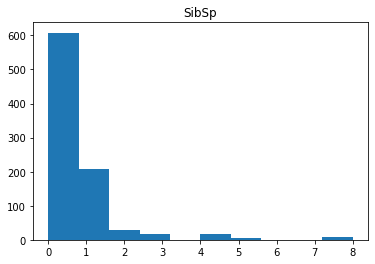

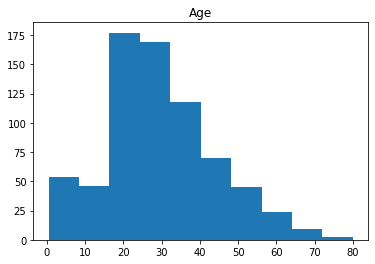

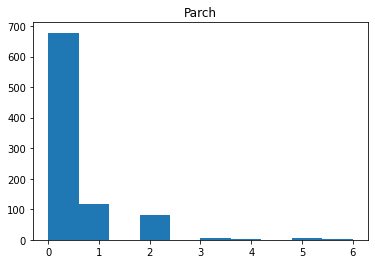

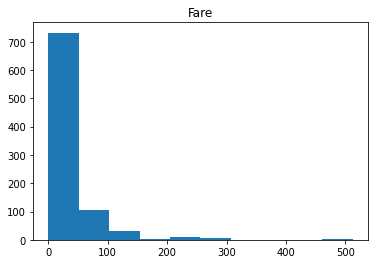

In [4]:
# distribution for all numberical features
for i in num_train.columns:
    plt.hist(num_train[i])
    plt.title(i)
    plt.show()

**Age is the only numerical feature that shows a loose normal distribution and is reasonably scaled.**

**All other features dont show any normal distribution and could be normalised.**

In [5]:
pd.pivot_table(training, index = 'Survived', values = num_train)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


**This table compares the numerical features with survived.**

**On average, younger passengers survived, and those who spent more on their fare survived.**

**Being apart of a family looks to improve your chances of survival, but having a spouse or more siblings decreases your chance of survival.
This is difficult to draw any conclusions from at this stage.**

**From this table the largest influencing feature on survivability is Fare.**

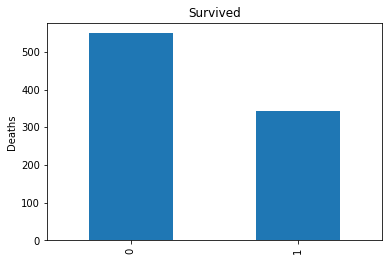

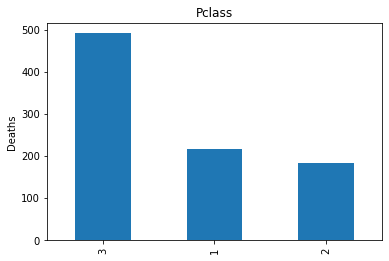

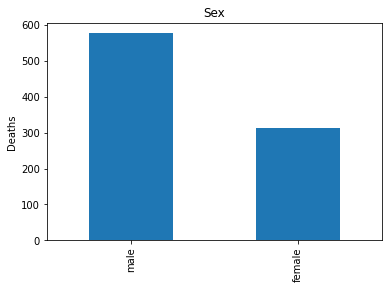

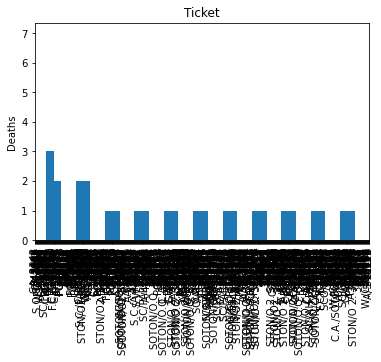

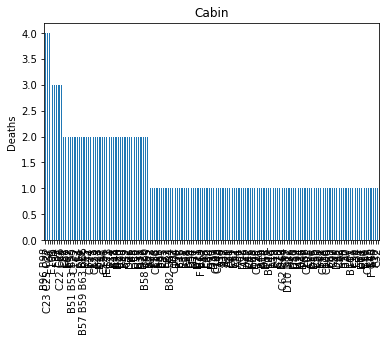

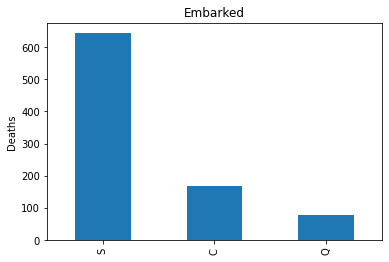

In [6]:
for i in nonnum_train.columns:
    freq_series = pd.Series(nonnum_train[i].value_counts())

    plt.figure()
    fig = freq_series.plot(kind='bar')
    fig.set_title(i)
    fig.set_ylabel('Deaths')

**From these bar charts, certain features show distinct correlation to the number of deaths, including: pclass, sex and embarked.
Further exploration of these features might show meaning behind the data.**

**Other features, cabin and ticket are messy, making it hard to derive meaning from.**

In [7]:
print(pd.pivot_table(nonnum_train, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print(pd.pivot_table(nonnum_train, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))
print(pd.pivot_table(nonnum_train, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217
Sex       female  male
Survived              
0             81   468
1            233   109


In [8]:
training['Cabin'].value_counts().head(10)

B96 B98        4
C23 C25 C27    4
G6             4
E101           3
D              3
F33            3
F2             3
C22 C26        3
C92            2
C68            2
Name: Cabin, dtype: int64

## 2) Feature engineering

In [9]:
lam = (lambda x: 0 if pd.isna(x) else len(x.split(" ")))
# function returns 0 if value is not available in df, return length of list if value(s) found
training['Cabin_mul'] = training.Cabin.apply(lam)
print(training['Cabin_mul'].value_counts())

pd.pivot_table(training, index = 'Survived', columns = 'Cabin_mul', values = 'Ticket' ,aggfunc ='count')

0    687
1    180
2     16
3      6
4      2
Name: Cabin_mul, dtype: int64


Cabin_mul,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


**creating a new feature via a function to return the number of cabins booked under a single ticket.
the data is incomplete, showing the majority of tickets with no cabin, however it shouldnt be a problem**

**this column is useful for determining if booking multiple cabins influences survival rates.**

**inside the table, comparison between survival and cabins_mul shows a increase in survival rates with multiple cabins (2+) in a range of 50% to 100% survival, greater than the 38% chance of survival with fewer cabins**

**this proves to be a useful feature of the dataset as the data shows correlation to the target feature**

In [10]:
lam2 = (lambda x: str(x)[0])
# function returns first item inside string list, returning the letter of the cabin, or lack of cabin object
training['Cabin_let'] = training['Cabin'].apply(lam2)
print(training['Cabin_let'].value_counts())
pd.pivot_table(training, index = 'Survived', columns = 'Cabin_let', values = 'Ticket' ,aggfunc ='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_let, dtype: int64


Cabin_let,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


**The table comparing the letters on the ticket and survival shows certain tickets which increase or decrease rate of survival within realistic bounds**

**the result of this feature engineering proves to be a useful feature of the dataset as the data shows correlation to the column survival**

In [11]:
def ticket_str(x):
    p1 = ''.join(x.split(" ")[:-1])
    p1 = p1.replace('/', '').replace('.', '').lower()
    return p1
    
def ticket_num(x):
    if x.isnumeric():
        return 1
    return 0

training['Ticket_str'] = training['Ticket'].apply(ticket_str)
training['Ticket_num'] = training['Ticket'].apply(ticket_num)

In [12]:
pd.pivot_table(training, index = 'Survived', columns = 'Ticket_num', values = 'Ticket' ,aggfunc ='count')

Ticket_num,0,1
Survived,,
0,142,407
1,88,254


In [13]:
pd.pivot_table(training, index = 'Survived', columns = 'Ticket_str', values = 'Ticket' ,aggfunc ='count')

Ticket_str,,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


**new features breaking down ticket into numeric boolean and the letters on the ticket provide more value than ticket as a whole**

**the string portion of the ticket still doesnt show any particular value or relevant correlation to survived**

In [14]:
def get_title(x):
    title = x.split(",")[1].split('.')[0].strip()
    return title

In [15]:
training['Title'] = training.Name.apply(get_title)
pd.pivot_table(training, index = 'Survived', columns = 'Title', values = 'Ticket' ,aggfunc ='count')

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,4.0,1.0,NaN,1.0,17.0,55.0,NaN,NaN,436.0,26.0,NaN,6.0,NaN,NaN
1,NaN,1.0,NaN,3.0,NaN,1.0,1.0,23.0,127.0,2.0,1.0,81.0,99.0,1.0,NaN,1.0,1.0


new feature Title shows strong correlation with survived, making this a valuable addition

having explored the data, only certain variables are now useful for predicting survived including:

* title, ticket_num, cabin_let, cabin_mul, pclass, embarked, sex, fare, age, parch, sibsp



## 3) Data preprocessing

In [16]:
training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN

all_data = pd.concat([training, test])

all_data.dropna(subset=['Embarked'],inplace = True)

all_data.Age = all_data.Age.fillna(training.Age.median())
all_data.Fare = all_data.Fare.fillna(training.Fare.median())

all_data['norm_fare'] = np.log(all_data.Fare+1)

all_data['Cabin_mul'] = all_data.Cabin.apply(lam)
all_data['Cabin_let'] = all_data['Cabin'].apply(lam2)
all_data['Ticket_str'] = all_data['Ticket'].apply(ticket_str)
all_data['Ticket_num'] = all_data['Ticket'].apply(ticket_num)
all_data['Title'] = all_data.Name.apply(get_title)


all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare',
                                       'Embarked','Cabin_let','Cabin_mul','Ticket_num','Title','train_test']])

x_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
x_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

In [17]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']])

x_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
x_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

## 4) Model building

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [19]:
lr = LogisticRegression(max_iter = 1500)
cv = cross_val_score(lr, x_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean()*100)

[0.80898876 0.81460674 0.80337079 0.82022472 0.85310734]
82.00596711737447


In [20]:
svc = SVC(probability = True)
cv = cross_val_score(svc, x_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean()*100)

[0.83707865 0.8258427  0.8258427  0.79775281 0.85875706]
82.90547832158953


In [21]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,x_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean()*100)

[0.79775281 0.79213483 0.83707865 0.79775281 0.85310734]
81.55652891512727


In [22]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr), ('knn',knn), ('svc',svc)], voting = 'soft') 

cv = cross_val_score(voting_clf, x_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean()*100)

[0.8258427  0.8258427  0.83146067 0.79775281 0.85875706]
82.79311877102774


in a soft voting classifier, each model return their respective confidence on survival of given data

## 5) Model tuning

In [23]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [24]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [25]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(x_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.6s


Logistic Regression
Best Score: 0.8223132101821875
Best Parameters: {'C': 29.763514416313132, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished


In [26]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(x_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.7s


KNN
Best Score: 0.826769504221418
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.0s finished


In [27]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(x_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  3.2min finished


SVC
Best Score: 0.8290547832158953
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


after tuning, the support vector classifier shows the greatest cross validation performance, analysis of these models is further require to understand bias and variance

In [28]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('svc',best_svc)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('svc',best_svc), ('lr', best_lr)], voting = 'soft') 

print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,x_train,y_train,cv=5).mean())

print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,x_train,y_train,cv=5).mean())

print('voting_clf_all mean :',cross_val_score(voting_clf_all,x_train,y_train,cv=5).mean())

voting_clf_hard mean : 0.7930552910556719
voting_clf_soft mean : 0.7998222560782072
voting_clf_all mean : 0.8178061321653018


In [29]:
voting_clf_hard.fit(x_train_scaled, y_train)
voting_clf_soft.fit(x_train_scaled, y_train)
voting_clf_all.fit(x_train_scaled, y_train)

y_hat_vc_hard = voting_clf_hard.predict(x_test_scaled).astype(int)
y_hat_vc_soft = voting_clf_soft.predict(x_test_scaled).astype(int)
y_hat_vc_all = voting_clf_all.predict(x_test_scaled).astype(int)

In [30]:
final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_hard}
submission = pd.DataFrame(data=final_data)

final_data_2= {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_soft}
submission_2= pd.DataFrame(data=final_data_2)

final_data_3= {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_all}
submission_3= pd.DataFrame(data=final_data_3)

submission.to_csv('submission_vc_hard.csv',index=False)
submission_2.to_csv('submission_vc_soft.csv', index=False)
submission_3.to_csv('submission_vc_all.csv', index=False)